In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read CSV file into a DataFrame
csv_file_path = "summary_sims_two_objectives_cost_and_clouds.csv"

                            instance  best  average_score
solver_name front_strategy                               
gurobi      gavanelli             22    13       0.999131
            saugmecon             24    23       0.999483
ortools-py  gavanelli             24    10       0.985588
            saugmecon             24    24       1.000000


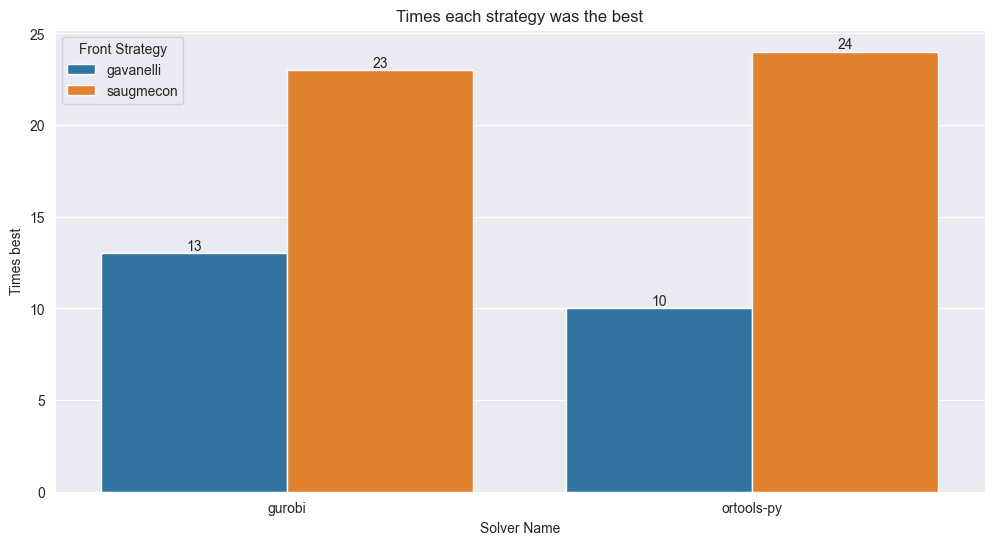

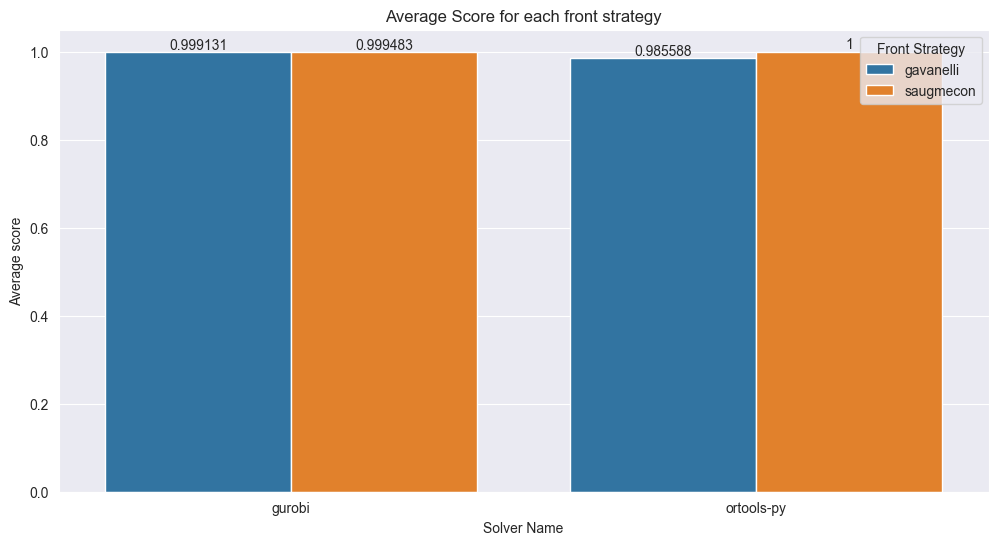

In [2]:
df = pd.read_csv(csv_file_path, delimiter=';')

# Function to calculate score for each front_strategy
def calculate_score(group):
    best_hypervolume = group.loc[group['hypervolume'].idxmax(), 'hypervolume']
    group['score'] = group['hypervolume'] / best_hypervolume
    return group

# Apply the function to calculate scores
df_score_by_front_strategy = df.groupby(['instance', 'solver_name']).apply(calculate_score)
df_score_by_front_strategy =  df_score_by_front_strategy.drop(columns='solver_name')

df_total_front_by_solver = df.groupby(['solver_name', 'front_strategy'])['instance'].count()
df_best_front_by_solver = df_score_by_front_strategy[df_score_by_front_strategy['score'] == 1.0].groupby(['solver_name', 'front_strategy']).size().rename('best').to_frame()
df_avg_score_by_front_strategy = df_score_by_front_strategy.groupby(['solver_name', 'front_strategy'])['score'].mean().rename('average_score').to_frame()

df_total_best = pd.merge(df_total_front_by_solver, df_best_front_by_solver, left_index=True, right_index=True)
# add a column with the average score for each front strategy
df_total_best_avg_score = pd.merge(df_total_best, df_avg_score_by_front_strategy, left_index=True, right_index=True)
print(df_total_best_avg_score)

# Plotting
plt.figure(figsize=(12, 6))
# Adding text labels on top of bars
ax = sns.barplot(x=df_total_best_avg_score.index.get_level_values('solver_name'), y='best', hue=df_total_best_avg_score.index.get_level_values('front_strategy'), data=df_total_best_avg_score)
for p in ax.containers:
    ax.bar_label(p, label_type='edge')
    
# Adding labels and legend
plt.title('Times each strategy was the best')
plt.xlabel('Solver Name')
plt.ylabel('Times best')
plt.legend(title='Front Strategy')
plt.show()

# Create the second graph
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=df_total_best_avg_score.index.get_level_values('solver_name'), y='average_score', hue=df_total_best_avg_score.index.get_level_values('front_strategy'), data=df_total_best_avg_score)
for p in ax.containers:
    ax.bar_label(p, label_type='edge')

# Adding labels and legend
plt.title('Average Score for each front strategy')
plt.xlabel('Solver Name')
plt.ylabel('Average score')
plt.legend(title='Front Strategy')
plt.show()


In [19]:
# Plot the time and the number of solutions for each instance
def calculate_time_score(group):
    best_time = group.loc[group['time_solver_sec'].idxmin(), 'time_solver_sec']
    group['time_score'] = group['time_solver_sec'] / best_time
    return group

def calculate_number_of_solutions_score(group):
    best_number_of_solutions = group.loc[group['number_of_solutions'].idxmin(), 'number_of_solutions']
    group['number_of_solutions_score'] = group['number_of_solutions'] / best_number_of_solutions
    return group

def merge_solver_front_strategy_names(group):
    group['solver_front_strategy'] = group['solver_name'] + ' ' + group['front_strategy']
    return group

# Apply the function to calculate scores
df_time_number_solutions = df.groupby(['instance']).apply(calculate_number_of_solutions_score)
df_time = df.groupby(['instance']).apply(calculate_time_score)
df_time_number_solutions['time_score'] = df_time['time_score']

df_solver_front = df.groupby(['instance']).apply(merge_solver_front_strategy_names)
df_time_number_solutions['solver_front_strategy'] = df_solver_front['solver_front_strategy']

df_time_number_solutions = df_time_number_solutions[['instance', 'solver_front_strategy', 'time_score', 'time_solver_sec',
                                                     'number_of_solutions_score', 'number_of_solutions', 'exhaustive']]


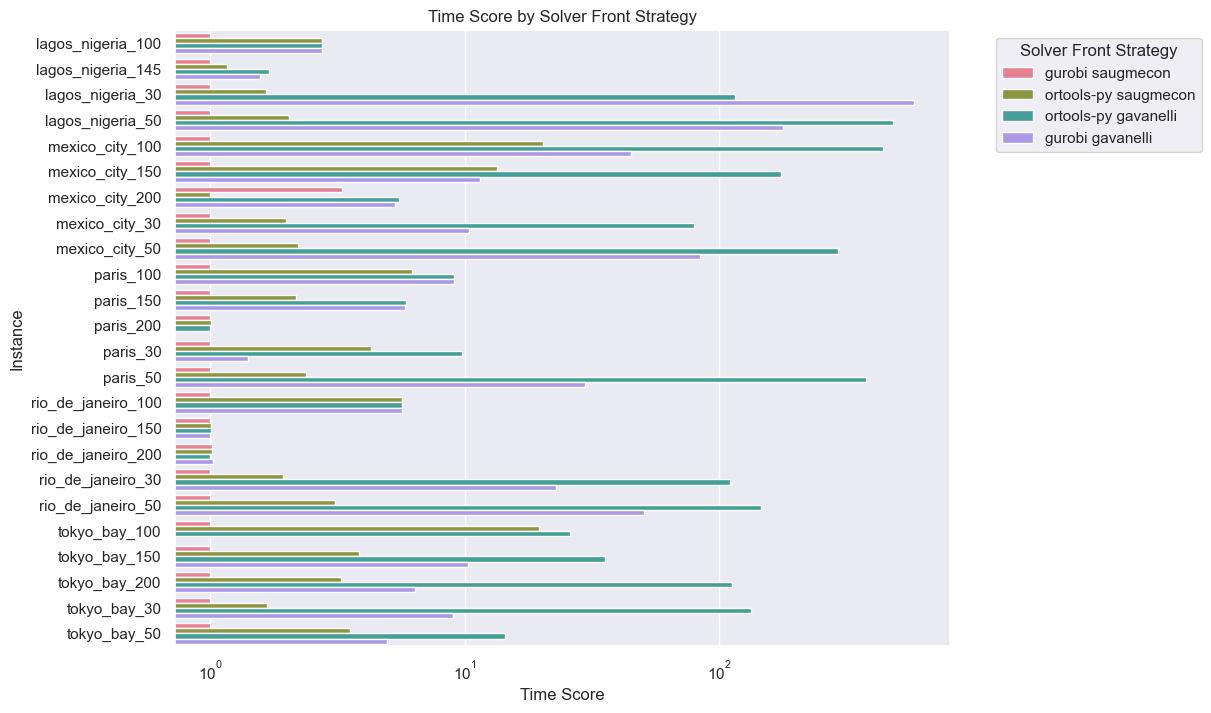

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
plt.figure(figsize=(10, 8))
sns.set_theme()

# Define a threshold for applying a logarithmic scale
log_threshold = 10  # Adjust the threshold as needed

# Create a color palette for solver_front_strategy
palette = sns.color_palette("husl", len(df_time_number_solutions['solver_front_strategy'].unique()))

# Plot time scores with a conditional logarithmic x-axis
sns.barplot(x='time_score', y='instance', hue='solver_front_strategy', data=df_time_number_solutions,
            palette=palette, orient='h')

plt.title('Time Score by Solver Front Strategy')
plt.xlabel('Time Score')
plt.ylabel('Instance')
plt.legend(title='Solver Front Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')

# Apply a logarithmic scale only for values greater than the threshold
if df_time_number_solutions['time_score'].max() > log_threshold:
    plt.xscale('log')
    
plt.show()
